In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [26]:
### setup ###

### imports

import random
import sys
sys.path.append('/Users/kszczepaniak/Code/phage-pipeline-env/phage-pipeline')
import submodules.pdf.domain_split as ds
from lib_phage.clustering import cluster_proteins
from lib_phage.utils import setup_dir_tree, fetch_and_rename_protein_ids, build_hhr_table
from lib_phage.utils import process_phanotate_output, create_reprseq_profile_from_clustering
from lib_phage.logs import check_input_repr_prot_selection, validate_output_repr_prot_selection
from lib_phage.logs import check_input_all_vs_all_HMM, save_params_hhblits, validate_output_hhblits
from lib_phage.logs import validate_create_db, validate_search_all_vs_all, validate_input_ECF, validate_output_ECF
from lib_phage.prot_compare import save_individual_seqs, run_hhblits, build_hh_db, run_all_vs_all
from lib_phage.ecf_finder_wrapper import load_and_filter_data, store_scan_results

### run mode
run_mode = 'mmseqs' # profile creation mode [mmseqs/hhblits]

### paths

# data sources

# cds_all_filepath = '/Users/kszczepaniak/Data/Phage/Rafal_Dropbox/data/input/combined/coding-seqs/cds-aa.fa.gz'
phanotate_filepath = '/Users/kszczepaniak/Data/Phage/phage-pipeline-input-dev/seq-test.phanotate.txt'

# work dirs
work_dir = '/Users/kszczepaniak/Data/Phage/phage-pipeline-workdir-dev/'
setup_dir_tree(work_dir)

# binaries and libraries

mmseqs_binpath  = 'mmseqs'
uniref_db_path  = '/Users/kszczepaniak/Data/Phage/db/UniRef30_2020_06/UniRef30_2020_06'
hhsuite_bins    = '/Users/kszczepaniak/Tools/hh-suite/build/bin'
hhsuite_scripts = '/Users/kszczepaniak/Tools/hh-suite/build/scripts'

/tmp/ directory already set up
/tmp/repr-proteins/ directory already set up
/tmp/mmseqs/ directory already set up
/tmp/all-by-all/ directory already set up
/tmp/all-by-all/individual-seqs/ directory already set up
/input/ directory already set up
/input/phanotate/ directory already set up
/input/coding-seqs/ directory already set up
/output/ directory already set up
/output/prot-families/ directory already set up
/output/prot-families/representative/ directory already set up
/intermediate/ directory already set up
/intermediate/prot-families/ directory already set up
/intermediate/prot-families/profiles/hhblits/ directory already set up
/intermediate/prot-families/profiles/mmseqs/ directory already set up
/intermediate/prot-families/all-by-all/hhblits/ directory already set up
/intermediate/prot-families/all-by-all/mmseqs/ directory already set up
/intermediate/prot-families/db/hhblits/ directory already set up
/intermediate/prot-families/db/mmseqs/ directory already set up
/log/ direc

In [3]:
### Create protein db from Phanotate data ###

# translate Phanotate & compress with bgzip
process_phanotate_output(phanotate_filepath=phanotate_filepath, work_dir=work_dir)

All fasta translated. File compressed.


In [33]:
### Get representative proteins ###

# set clustering params
cluster_params_min_seqid   = 0.3
cluster_params_sensitivity = 7
cluster_params_coverage    = 0.95

# check input files integrity & if this step was already executed:
# if it was warn about data overwrite
if check_input_repr_prot_selection():

    # perform clustering
    clustering_filepath, clustering_msa_filepath = cluster_proteins(input_fasta_filepath=work_dir + 'input/coding-seqs/cds-aa.fa.gz',
                                           output_dirpath=work_dir + 'output/prot-families/representative',
                                           mmseqs_tempdir=work_dir + 'tmp/mmseqs',
                                           mmseqs_binpath=mmseqs_binpath,
                                           cluster_params_min_seqid=cluster_params_min_seqid,
                                           cluster_params_sensitivity=cluster_params_sensitivity,
                                           cluster_params_coverage=cluster_params_coverage,
                                           verbose=True)

    no_repr_prot, name_table_filepath = fetch_and_rename_protein_ids(work_dir, clustering_filepath, 
                                                                     work_dir + 'input/coding-seqs/cds-aa.fa.gz')

    # verify output and save log file
    validate_output_repr_prot_selection(work_dir=work_dir,
                                        output_dirpath=work_dir + 'output/prot-families/representative',
                                        cluster_params_min_seqid=cluster_params_min_seqid,
                                        cluster_params_sensitivity=cluster_params_sensitivity,
                                        cluster_params_coverage=cluster_params_coverage)

Creating db... Done!
Clustering... Done!
Generating a clustering table... Done!
Creating MSA... Done!
Validation success, log file stored.


In [28]:
### Create profiles from mmseqs clusters ###
# profile for singleton in clustering is the sequence itself

create_reprseq_profile_from_clustering(clustering_filepath, clustering_msa_filepath,
                                       cds_all_filepath = work_dir + 'input/coding-seqs/cds-aa.fa',
                                       profile_outdir = work_dir + 'intermediate/prot-families/profiles/mmseqs')

In [29]:
### Perform all vs all comparison ###
# create profiles for each protein with hhblits #

# set create profiles params
cpu  = 2 # max number of CPUs to be used in the step
n    = 1
mact = 0.35
p    = 90
qid  = 10
cov  = 10

if run_mode == 'hhblits': # execute this only when creating profiles with hhblits

    # validate previous step
    if check_input_all_vs_all_HMM(work_dir=work_dir, force=True):

        # execute current step
        save_individual_seqs(work_dir=work_dir)

        run_hhblits(work_dir=work_dir, hhsuite_bins=hhsuite_bins, hhsuite_scripts=hhsuite_scripts, cpu=cpu, 
                    uniref_db_path=uniref_db_path, n=n, mact=mact, p=p, qid=qid, cov=cov)

        # save params to log
        save_params_hhblits(work_dir=work_dir, n=n, mact=mact, p=p, qid=qid, cov=cov)

In [30]:
# Build db #

if run_mode == 'hhblits': # execute this only when creating profiles with hhblits

    # validate previous step
    if validate_output_hhblits(work_dir):

        # execute current step
        build_hh_db(work_dir=work_dir, hhsuite_bins=hhsuite_bins,
                    hhsuite_scripts=hhsuite_scripts, verbose=True, run_mode=run_mode)
        
elif run_mode == 'mmseqs':
    # execute current step
    build_hh_db(work_dir=work_dir, hhsuite_bins=hhsuite_bins,
                hhsuite_scripts=hhsuite_scripts, verbose=True, run_mode=run_mode)


Database already exists. Overwrite? [y/n]y
Database cleaned.
Concatenated a3m alignments.
Created HMM profiles.
Created column state (CS) sequence database.
DB sorted.
DB successfuly created.


In [31]:
# search all vs all #

# set all vs all search params
cpu  = 2 # max number of CPUs to be used in the step
n    = 1
p    = 90

if validate_create_db(work_dir=work_dir):

    run_all_vs_all(work_dir=work_dir, hhsuite_bins=hhsuite_bins, 
                   hhsuite_scripts=hhsuite_scripts, cpu=cpu, n=n, 
                   p=p, a3m_wildcard='reprseq*a3m', run_mode=run_mode)

Parameters saved, log file stored.


In [32]:
# create results table #

# check if previous step complete
if validate_search_all_vs_all(work_dir, run_mode=run_mode):
    
    # create results table
    build_hhr_table(work_dir, run_mode=run_mode)


HHblits all-vs-all step complete. Updated status.


In [ ]:
### Perform database search with profiles comparison ###

# set database search params
cpu  = 2 # max number of CPUs to be used in the step
n    = 1
mact = 0.35
p    = 90
qid  = 10
cov  = 10

if run_mode == 'hhblits': # execute this only when creating profiles with hhblits

    # validate previous step
    if check_input_all_vs_all_HMM(work_dir=work_dir, force=True):

        # execute current step
        save_individual_seqs(work_dir=work_dir)

        run_hhblits(work_dir=work_dir, hhsuite_bins=hhsuite_bins, hhsuite_scripts=hhsuite_scripts, cpu=cpu, 
                    uniref_db_path=uniref_db_path, n=n, mact=mact, p=p, qid=qid, cov=cov)

        # save params to log
        save_params_hhblits(work_dir=work_dir, n=n, mact=mact, p=p, qid=qid, cov=cov)

PARAMS 0.5 5
[334, 454]
[333, 333]
[455, 455]
[2, 112]


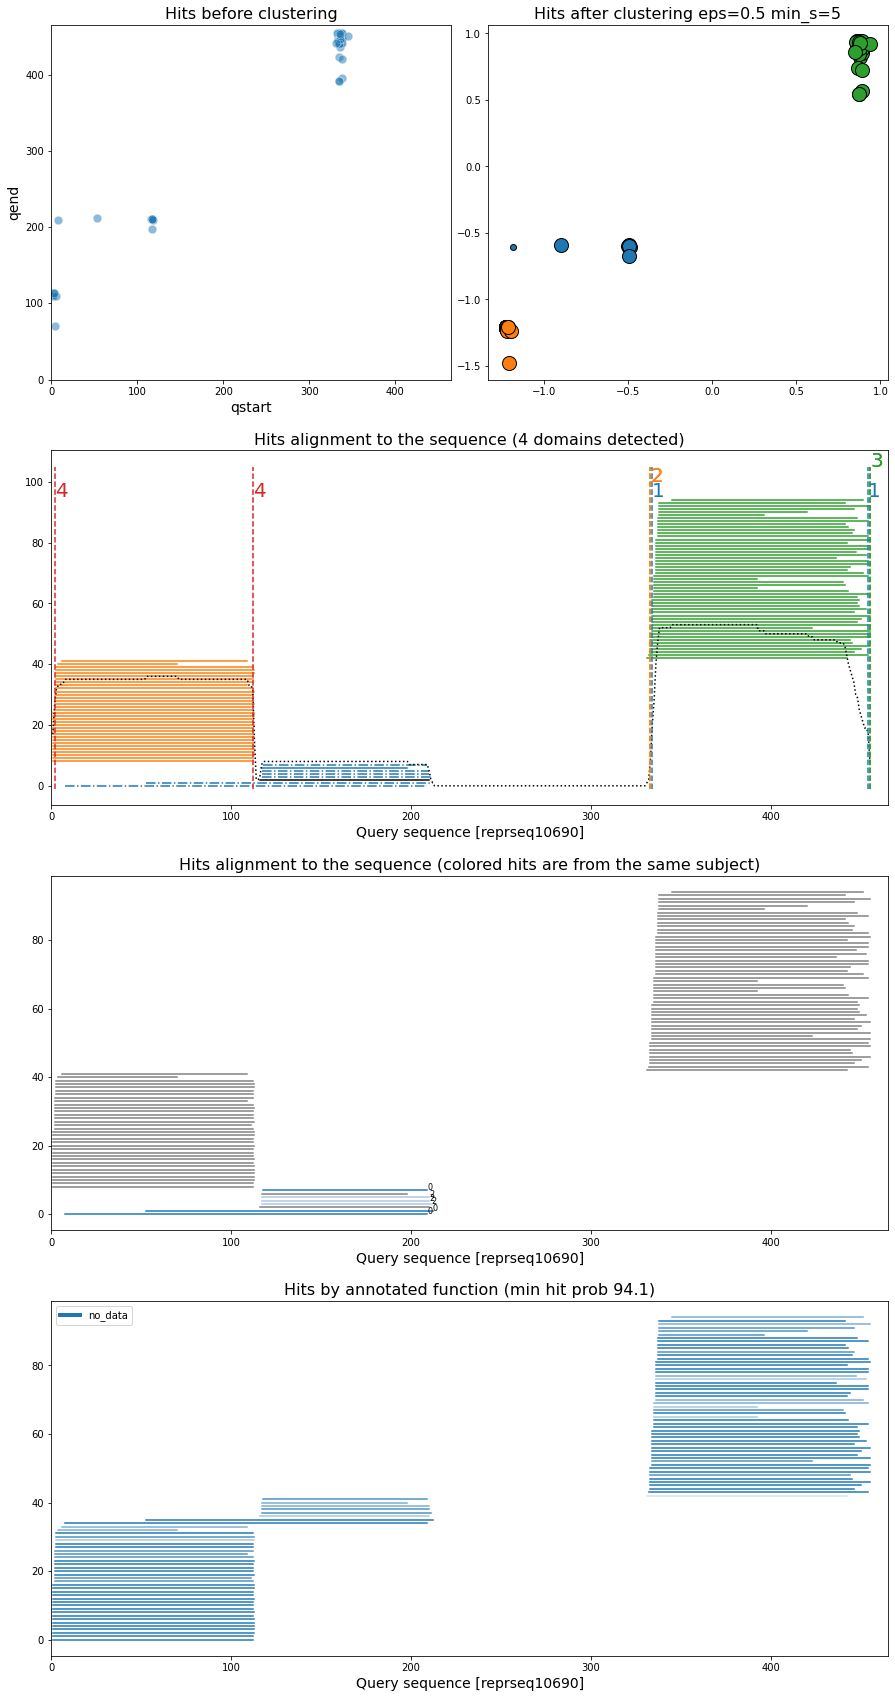

In [7]:
### Analysis - find ECFs ###

# set input/output paths
dataset_name = 'data_260221' # write your custom name (appended to the results files)
ecf_runmode  = 'benchmark' # options: 'benchmark', 'scan', 'scan-min'

# set data filtering params
prob_threshold  = 95.0
eval_threshold  = 1e-03
coverage_cutoff = 0.5 # minimal coverage of hit to total query length or maximum when using qcov/scov filter
min_hit_len     = 20 # minimal length of the hit (i.e. qend - qstart)
filters_params  = {'prob_threshold':prob_threshold, 'eval_threshold':eval_threshold, 
                   'coverage_cutoff':coverage_cutoff, 'min_hit_len':min_hit_len}
# set filters that will be applied
# available filters: prob, eval, self, cov, self-full, cov-both
# cov is qcov and filter is passing when greater than cutoff while cov-both passes when less than cutoff
filters_used   = ['eval', 'self-full', 'cov-both', 'hit-len']

# algorithm: clustering - for full scan mode
clust_eps        = 0.5 # clustering epsilon parameter
clust_min_sample = 5 # minimum number of samples to create cluster
# algorithm: clustering - for benchmark mode
eps_list         = [0.5]
min_samples_list = [5]

# algorithm: general
min_coverage   = 0.1 # minimal hit coverage at positions to consider it a domain in all steps of algorithm
domain_min_len = 0.05 # minimal length [fraction of full query length] of domain that can be annotated
# algorithm: similiar domains merge
merge_size_cutoff   = 0.9 # ratio of domain1/domain2 and domain2/domain1 must be no smaller than this fraction
merge_shared_cutoff = 0.9 # ratio of set of common positions to set of union of positions must be no smaller than this fraction
# algorithm: steps options
steps = {'merge_similiar': True, # if True then similiar regions will be merged according to params above
         'resolve_no_domain': False # if True then regions with high coverage of hits and without domains will be annotated as domains at the end of algorithm
}

def convert_list_to_benchmark_input(lst):
    """Quick fix function to simplyfy input of desired prot_ids.
    Move to package."""
    
    d = {'list':{}}
    for i in lst:
        d['list'][i] = {}
    
    return d

if validate_input_ECF(work_dir):
    
    # apply data filtering
    hhr_table, annotation_table, dataset_size, id_width = load_and_filter_data(work_dir, filters_used, filters_params)
    hhr_table = ds.annot.add_function_column_to_df(hhr_table, annotation_table, no_data=True) # annotation not ready for new set
    
    # perform ECF search
    if ecf_runmode == 'benchmark':
        
        # to create random sample    
        sample = random.sample(range(1,dataset_size), 30)
        benchmark_set = {'random': { i:{} for i in sample } }
        
        # define protids to scan
        benchmark_set = {'random': {16469: {}, 13067: {}, 10248: {}, 
                                   18698: {}, 24602: {}, 7231: {}, 27068: {}, 15929: {}, 
                                    8094: {}, 1194: {}, 3816: {}, 531: {}, 21035: {}, 24321: {},
                                    3056: {}, 79: {}, 2652: {}, 20803: {}, 25587: {}, 
                                    11157: {}, 4488: {}, 3373: {}, 26024: {}}}
        
        benchmark_set = {'random': {26087: {}}}
        
        prot_lst      = [10690]
        benchmark_set = convert_list_to_benchmark_input(prot_lst)
        
        # 10162: {} # crushes when 50% filter applied

        for funct in benchmark_set.keys():
            benchmark_result = ds.funct.run_benchmark(benchmark_set[funct], hhr_table, eps_list=eps_list, id_width=id_width,
                                             min_samples_list=min_samples_list, only_get_plots=True, plot_type='show',
                                             names_dict={}, clustering_pngs_dirpath=work_dir + 'output/ecf-search/plots',
                                             min_coverage=min_coverage, domain_min_len=domain_min_len, 
                                             merge_size_cutoff=merge_size_cutoff, merge_shared_cutoff=merge_shared_cutoff,
                                             dataset_name=dataset_name, db_tables={}, steps=steps, prefix_id='reprseq')

    elif ecf_runmode == 'scan':
        
         ### !!!! DEV - cut list to get faster devel computation
        import random
        ids = list(hhr_table['qname'].unique())
        rp = random.sample(ids, 300)
        hhr_table = hhr_table[hhr_table['qname'].isin(rp)]
        ### !!! END-DEV
        
        ECFs_results = ds.funct.run_domain_finder(hhr_table, clust_eps, clust_min_sample, min_coverage, 
                                                   domain_min_len, merge_size_cutoff, merge_shared_cutoff,
                                                   steps)
        store_scan_results(work_dir, ECFs_results)
        
    elif ecf_runmode == 'scan-min':
        
         ### !!!! DEV - cut list to get faster devel computation
#         import random
#         ids = list(hhr_table['qname'].unique())
#         rp = random.sample(ids, 30)
#         hhr_table = hhr_table[hhr_table['qname'].isin(rp)]
        ### !!! END-DEV
        
        ECFs_results = ds.funct.run_domain_finder_min(hhr_table, clust_eps, clust_min_sample, min_coverage, 
                                                   domain_min_len, merge_size_cutoff, merge_shared_cutoff,
                                                   steps)
        store_scan_results(work_dir, ECFs_results, mode='pickle')

    # verify output and save log file
    validate_output_ECF(work_dir, ecf_runmode, filters_params, filters_used, clust_eps, clust_min_sample, 
                        min_coverage, domain_min_len, merge_size_cutoff, 
                        merge_shared_cutoff, steps)



In [6]:
hhr_table

,qname,qstart,qend,qlength,sname,sstart,send,slength,pident,bitscore,eval,prob,pval,qcov,scov,hlen,sfunct
2984,reprseq00051,200,396,570,reprseq00051,6,189,570,16,95.5,4.300000e-07,97.1,6.000000e-11,0.345614,0.322807,197,no_data
2991,reprseq00051,8,189,570,reprseq00051,202,396,570,15,85.1,8.900000e-06,96.4,1.300000e-09,0.319298,0.342105,182,no_data
3073,reprseq00052,461,525,1614,reprseq00052,482,546,1614,14,106.4,1.500000e-05,96.2,2.200000e-09,0.040273,0.040273,65,no_data
3084,reprseq00052,483,546,1614,reprseq00052,462,525,1614,14,96.5,1.400000e-04,95.3,2.100000e-08,0.039653,0.039653,64,no_data
6568,reprseq00135,307,608,665,reprseq00135,394,665,665,26,350.7,1.900000e-42,100.0,2.400000e-46,0.454135,0.409023,302,no_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382395,reprseq34462,585,647,925,reprseq07896,33,75,392,22,77.2,1.400000e-04,95.3,2.100000e-08,0.068108,0.109694,63,no_data
1382396,reprseq34462,587,666,925,reprseq27288,117,187,292,25,69.5,4.800000e-04,94.6,7.300000e-08,0.086486,0.243151,80,no_data
1382397,reprseq34462,536,657,925,reprseq27361,345,442,922,25,77.5,9.300000e-04,94.1,1.300000e-07,0.131892,0.106291,122,no_data
1382425,reprseq34463,79,175,200,reprseq01589,92,187,214,14,84.6,2.500000e-09,97.9,3.200000e-13,0.485000,0.448598,97,no_data


In [10]:
### Analysis - ECFs stats ###
ECFs_results

{'reprseq08395': {0: {'nb_hits': 113,
   'avg_hits_overlap': 0.4853428658905902,
   'ecf_span': 241,
   'avg_hit_len_to_ecf_span': 0.5005691624132487,
   'span_to_qlength': 0.667590027700831,
   'cluster_data':                qname  qstart  qend  qlength         sname  sstart  send  \
   336800  reprseq08395      15   186      361  reprseq23226     132   344   
   336671  reprseq08395      25   186      361  reprseq21613      50   229   
   336773  reprseq08395      25   186      361  reprseq17508     103   275   
   336798  reprseq08395      25   186      361  reprseq22504      94   273   
   336793  reprseq08395      25   186      361  reprseq17504     113   297   
   ...              ...     ...   ...      ...           ...     ...   ...   
   336859  reprseq08395     191   249      361  reprseq28550       4    63   
   336876  reprseq08395     192   249      361  reprseq28557       3    61   
   336891  reprseq08395     193   249      361  reprseq11923      48   106   
   336799  r